In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from graph_nets import blocks
from graph_nets import graphs
from graph_nets import modules
from graph_nets import utils_np
from graph_nets import utils_tf
from graph_nets.demos.models import EncodeProcessDecode as EPD

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import sonnet as snt
import tensorflow as tf
import h5py
from progressbar import progressbar
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

pi = np.pi
twopi=np.pi*2.

Let's test our TF Interaction Network code with a simple model  
The model is a very simple traffic model where the only node/edge feature  
is how many cars contained. The network should be able to learn that if an  
edge has a car from its sender, then that node will have +1 more cars next step.  

We should include a pattern for the cars from a given node.  
Let's just have them aimlessly whirlpool clockwise

In [3]:
nnode = 100
nedge=None
nnode_feat = 1
nedge_feat = 1
NCAR = 500
maxnbr = 4
NTG = 24

In [14]:
def dist_from(ref,rs):
    return np.linalg.norm((ref-rs),axis=1)

def get_edge_angle(nodedf,i,j):
    dx = nodedf.at[j,'x'] - nodedf.at[i,'x']
    dy = nodedf.at[j,'y'] - nodedf.at[i,'y']
    z = np.complex(dx,dy)
    return np.angle(z)

def get_edge_idx(edgedf,s,r):
    return edgedf[(edgedf['sender']==s) & (edgedf['receiver']==r)].index[0]

def get_node_idx(nodedf,nodeID):
    return int(np.argwhere(nodes.index==nodeID))

def copy_graph(graphs_tuple):
    return utils_np.data_dicts_to_graphs_tuple(
        utils_np.graphs_tuple_to_data_dicts(graphs_tuple))

def choose_nbr(nodedf,s):
    node = nodedf.loc[s]
    nbrs, angles, wdir = node['nbrs'], node['nbr_angles'], node['wdir']
    dth = np.abs(angles-wdir)
    
    # Everybody wants to keep whirlpooling
    # Smaller sigma means a more focused whirlpooling
    sigma=pi
    r = np.random.normal(scale=sigma)
    while abs(r)>pi:
        r = np.random.normal(scale=sigma)
    
    desire = wdir - r
    if desire<-pi: desire+=twopi
    elif desire>pi: desire-=twopi
    # Which nbr closest to this direction
    dth = np.abs(angles - desire)
    dth = np.where(dth<pi,dth,twopi-dth)
    nbr = nbrs[np.argmin(dth)]

    return nbr

def i2dtg(i):
    return [(i//NTG)%7, i%NTG]

def dset2graph(h5group,isnap):
    dset = h5group['step'+str(isnap)]
    d = {}
    for key,arr in dset.items():
        if key in ["n_edge","n_node"]: continue
        d.update({key:arr})
    g = utils_np.data_dicts_to_graphs_tuple([d])
    return g

def npcoords2nx(npcoords):
    nxpos = {}
    for idx,coords in enumerate(npcoords):
        nxpos.update({idx:(coords[0],coords[1])})
    return nxpos

def update(graph):
    new_node_feat = np.zeros((nnode,1),dtype=np.float)
    new_edge_feat = np.zeros((nedge,1),dtype=np.float)

    # edge_feat and edges (df) are matched along the index
    for i, ncar in enumerate(graph.edges):
        rec = edges.iloc[i]['receiver']
        new_node_feat[rec] += ncar[0]

    for i, ncar in enumerate(new_node_feat):
        n = ncar[0]
        if n>0:
            for car in range(int(n)):
                nbr = choose_nbr(nodes,i)
                featidx = get_edge_idx(edges,i,nbr)
                new_edge_feat[featidx] += 1                        

    olddtg = graph.globals[0]
    newglbls = i2dtg(olddtg[0]*NTG+olddtg[1]+1)
    return copy_graph(graph.replace(
                nodes=new_node_feat,
                edges=new_edge_feat,
                globals=np.array([newglbls])))

def draw_graph(graph, node_pos_dict):
    vmin,vmax = -0.5, 6
    e_vmin,e_vmax = -0.5, 3

    nodecols = graph.nodes.reshape(-1)
    edgecols = graph.edges.reshape(-1)

    graphs_nx = utils_np.graphs_tuple_to_networkxs(graph)
    fig,ax = plt.subplots(figsize=(10,10))
    nx.draw(graphs_nx[0],ax=ax,pos=node_pos_dict,node_color=nodecols,
            edge_color=edgecols,node_size=300,with_labels=True,
            cmap=plt.cm.winter,edge_cmap=plt.cm.winter,
            vmin=vmin,vmax=vmax,edge_vmin=e_vmin,edge_vmax=e_vmax,
            arrowsize=20)
    return fig,ax

In [7]:
xcoords = np.random.uniform(size=(nnode))
ycoords = np.random.uniform(size=(nnode))
nodes = pd.DataFrame(np.array([[x,y] for x,y in zip(xcoords,ycoords)]),columns=['x','y'])

# Connect neighbours and calc their angles
nodes['z'] = 0.
nodes['nbrs'] = ""
nodes['nbr_angles'] = ""
nodes['wdir'] = 0. # whirlpool direction
for idx,node in nodes.iterrows():
    nbrs = []
    angles = []
    nodes['z'] = dist_from(nodes.loc[idx,['x','y']].tolist(), nodes[['x','y']])
    nodes.sort_values(by=['z'],inplace=True)
    jcount=0
    for j in nodes.index[1:]:
        theta = get_edge_angle(nodes,idx,j)
        nbrs.append(j)
        angles.append(theta)
        jcount+=1
        if jcount==maxnbr:break
    nodes.at[idx,'nbrs'] = nbrs
    nodes.at[idx,'nbr_angles'] = angles

# Now reconnect existing edges to form two-way streets if needed
for idx,node in nodes.iterrows():
    newnbrs=[]
    nbrs=node['nbrs']
    for nbr in nbrs:
        nbrnbrs = nodes.loc[nbr,'nbrs']
        if idx not in nbrnbrs:
            theta = get_edge_angle(nodes,j,idx)
            nbrnbrs.append(idx)
            nodes.at[nbr,'nbrs'] = nbrnbrs
            nbrnbrangles = nodes.loc[nbr,'nbr_angles']
            nbrnbrangles.append(theta)
            nodes.at[nbr,'nbr_angles'] = nbrnbrangles
    
    # Rank nbrs based on whirlpool priority
    node_cnt = (node['x']-0.5,node['y']-0.5)
    node_theta = np.angle(np.complex(node_cnt[0],node_cnt[1]))
    whirldir = node_theta - pi/2. # clockwise procession
    if whirldir < -pi: whirldir += twopi
    nodes.at[idx,'wdir'] = whirldir

nodes = nodes.sort_index()
edges = pd.DataFrame(columns=['sender','receiver','angle'])
for idx,node in nodes.iterrows():
    for j,nbr in enumerate(node['nbrs']):
        edges = edges.append([{'sender': idx,
                               'receiver': nbr,
                               'angle': node['nbr_angles'][j]
                              }], ignore_index=True)
        
nedge = len(edges.index)

In [8]:
# Create feature dict
node_feat = np.zeros((nnode,1),dtype=np.float)
edge_feat = np.zeros((nedge,1),dtype=np.float)
senders = edges['sender'].to_numpy().astype(np.int)
receivers = edges['receiver'].to_numpy().astype(np.int)
glbls = np.array([0,0])

# Add cars
select_nodes = nodes[(nodes['x']>0.5) & (nodes['y']<0.5)].index
for _ in range(NCAR):
    inode = np.random.choice(select_nodes)
    nbr = np.random.choice(nodes.loc[inode,'nbrs'])
    node_feat[inode] += 1
    edgeidx = get_edge_idx(edges,inode,nbr)
    edge_feat[edgeidx] += 1
    
data_dict = {
    'globals': glbls,
    'nodes': node_feat,
    'edges': edge_feat,
    'senders': senders,
    'receivers': receivers
}

init_graph = utils_np.data_dicts_to_graphs_tuple([data_dict])

### Display the network

In [12]:
nxpos = {}
for idx,node in nodes.iterrows():
    nxpos.update({idx:(node['x'],node['y'])})

In [ ]:
nxpos = npcoords2nx(node_pos)

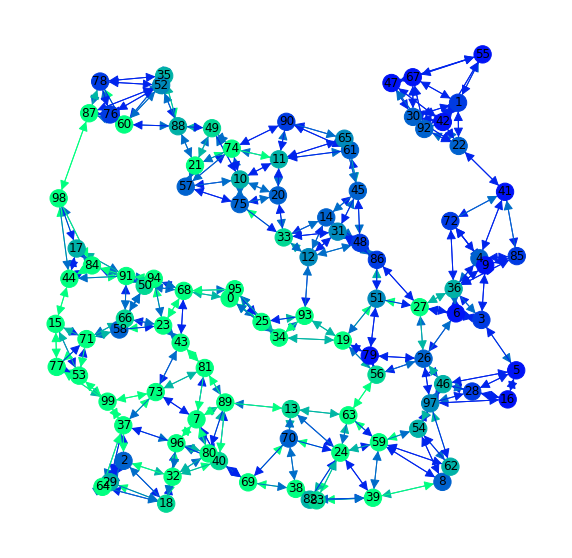

In [30]:
fig, ax = draw_graph(tmpinp,node_pos_dict)

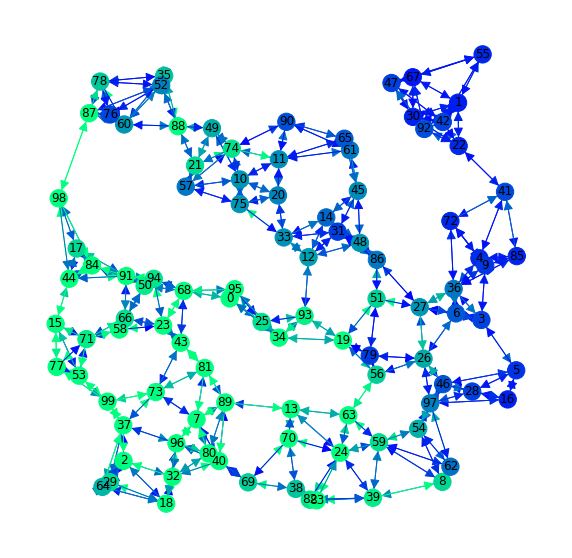

In [31]:
fig, ax = draw_graph(tmpout,node_pos_dict)

In [127]:
fig.savefig("inp.png")

### Simulate the procession for faster training, save to hdf5

In [22]:
equil = 50 # equilibration
nsim = 5000
h5name = "toys/e"+str(equil)+"s"+str(nsim)+"_2.hdf5"
ckptname = "e50s5000.ckpt"
saver = tf.train.Saver()

In [ ]:
h5 = h5py.File(h5name,'w')
h5sims = h5.create_group('sims')

# Write node coords
node_pos = np.zeros(shape=(nnode,2),dtype=np.float)
for idx,node in nodes.iterrows():
    node_pos[idx] = [node['x'],node['y']]
h5.create_dataset("node_pos",data=node_pos)

# Equilibrate
h5g = copy_graph(init_graph)
for _ in progressbar(range(equil)):
    h5g = update(h5g)
equil_graph = copy_graph(h5g)

h5g = copy_graph(equil_graph)
for step in progressbar(range(nsim)):
    group = h5sims.create_group("step"+str(step))
    d = utils_np.graphs_tuple_to_data_dicts(h5g)[0]
    for key,arr in d.items():
        group.create_dataset(key,data=arr)
    h5g = update(h5g)
    
h5.close()

### Create TF Graph and train

In [19]:
tf.reset_default_graph()

interaction_net = modules.InteractionNetwork(
    edge_model_fn=lambda: snt.Linear(output_size=1),
    node_model_fn=lambda: snt.Linear(output_size=1))

# Using data_dict from init
input_graph = utils_tf.placeholders_from_data_dicts([data_dict])
output_graph = interaction_net(input_graph)
lbl_graph = utils_tf.placeholders_from_data_dicts([data_dict])

loss = tf.losses.mean_squared_error(labels=lbl_graph.nodes, 
                                    predictions=output_graph.nodes)\
      +tf.losses.mean_squared_error(labels=lbl_graph.edges,
                                    predictions=output_graph.edges)
opt = tf.train.AdamOptimizer(learning_rate=1e-3)
loss_op = opt.minimize(loss)


In [136]:
try:
    h5.close()
except:
    pass

losses = []
with h5py.File(h5name,'r') as h5:
    h5group = h5['sims']
    node_pos = h5['node_pos']
    print("Training on run",h5name)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in progressbar(range(nsim)):
            if (i+1) >= nsim: break
            inp = dset2graph(h5group,i)
            lbl = dset2graph(h5group,i+1)

            train_dict = sess.run({
                'loss': loss,
                '_': loss_op,
                'output': output_graph
            }, feed_dict={
                input_graph: inp,
                lbl_graph: lbl
            })

            if i%100==0:
                losses.append(train_dict['loss'])
                
        saver.save(sess,"ckpts/"+ckptname)
        

  0% (1 of 5000) |                       | Elapsed Time: 0:00:00 ETA:   0:10:50

Training on run toys/e50s5000_2.hdf5


 99% (4992 of 5000) |################### | Elapsed Time: 0:00:28 ETA:   0:00:00

In [120]:
out = train_dict['output']

### Restore graphs and NN

In [28]:
inp_i = 0
lbl_i = -1
gen_update = True
saver = tf.train.Saver()

with h5py.File(h5name,'r') as h5:
    node_pos = h5['node_pos']
    node_pos_dict = npcoords2nx(node_pos)
    h5group = h5['sims']
    with tf.Session() as sess:
        saver.restore(sess,"ckpts/"+ckptname)
        tmpinp = dset2graph(h5group,inp_i)
        tmplbl = update(tmpinp) if gen_update else dset2graph(h5group,lbl_i)
        tmpout_dict = sess.run({'tmpout': output_graph},
                         feed_dict={
                             input_graph: tmpinp,
                             lbl_graph: tmplbl}
                         )
        
nedge = len(tmpinp.edges)

INFO:tensorflow:Restoring parameters from ckpts/e50s5000.ckpt


In [29]:
tmpout = tmpout_dict["tmpout"]